<a href="https://colab.research.google.com/github/MohamedBole/LangGraph-Powered-Python-Code-Assistant/blob/main/LangGraph_Powered_Python_Code_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install Dependance

In [1]:
!pip install langgraph langchain langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requ

In [2]:
import os
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
import langchain
import langchain_google_genai
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langgraph.graph.message import add_messages

In [3]:
# 1. Set the API key as an environment variable
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

# 2. Instantiate the LLM without explicitly passing the key
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0
)

# State Schema

In [47]:
class AgentState(TypedDict):
    messages : List[Union[HumanMessage, AIMessage]]
    task : str

#Explain Node

In [13]:
def explain(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI Python code  assistant, please explian my code provided to you."
    )
    response = llm.invoke([system_prompt] + state["messages"])
    print(f"\nAI Explaination:: {response.content}")
    return {"messages": [response]}

#Generate Node

In [14]:
def generate(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI Python code  assistant, please generate this code for me."
    )
    response = llm.invoke([system_prompt] + state["messages"])
    print(f"\nAI Generating Code:: {response.content}")
    return {"messages": [response]}

#Conditional Node

In [49]:
# Intent Classification Node
def classify_intent(state: AgentState) -> AgentState:
    user_input = state["messages"][-1].content if state["messages"] else ""

    # Create a prompt for the LLM to classify intent
    prompt = f"""
    Classify the intent of the following user input into one of these categories: 'explain' or 'generate'.

    Guidelines:
    - If the user asks to explain, understand, describe, or analyze code, return 'explain'
    - If the user asks to write, create, build, or generate code, return 'generate'

    User input: {user_input}
    Return only the intent as a single word (either 'explain' or 'generate').
    """

    try:
        response = llm.invoke(prompt)
        intent = response.content.strip().lower()
        if intent not in ["explain", "generate"]:
            intent = "explain"  # Default to explain if the response is invalid
    except Exception as e:
        print(f"Error in intent classification: {e}")
        intent = "explain"  # Fallback to explain on error

    print(f"Classified intent: {intent}")
    return {"task": intent}

In [48]:
# Router function for conditional edges
def router(state: AgentState) -> str:
    """Route to the appropriate node based on task."""
    return state["task"]

#Graph

In [50]:
# Create the graph
graph = StateGraph(AgentState)

# Add nodes
graph.add_node("classify_intent", classify_intent)
graph.add_node("explain", explain)
graph.add_node("generate", generate)

# Define edges
graph.add_edge(START, "classify_intent")
graph.add_conditional_edges(
    "classify_intent",
    router,
    {
        "explain": "explain",
        "generate": "generate",
    }
)
graph.add_edge("explain", END)
graph.add_edge("generate", END)

# Compile the graph
agent = graph.compile()

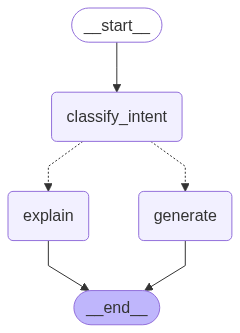

In [51]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

#Chat

In [54]:
# Chat Interface with Memory
class ChatSession:
    def __init__(self, agent):
        self.agent = agent
        self.conversation_history = []

    def add_to_history(self, message):
        """Add message to conversation history"""
        self.conversation_history.append(message)
        # Keep only last 10 messages to avoid token limits
        if len(self.conversation_history) > 10:
            self.conversation_history = self.conversation_history[-10:]

    def get_response(self, user_input):
        """Get response from the agent with conversation context"""
        # Create current message
        current_message = HumanMessage(content=user_input)

        # Combine history with current message
        all_messages = self.conversation_history + [current_message]

        # Get response from agent
        response = self.agent.invoke({
            "messages": all_messages,
            "task": ""
        })

        # Add both user input and AI response to history
        self.add_to_history(current_message)
        if response.get("messages"):
            self.add_to_history(response["messages"][-1])

        return response

In [57]:
def start_chat():
    """Start the interactive chat session"""
    print("🤖 Python Code Assistant")
    print("=" * 50)
    print("Hello! I'm your Python code assistant.")
    print("I can help you:")
    print("  • Explain Python code")
    print("  • Generate Python code")
    print("  • Answer programming questions")
    print("\nType 'exit' to quit the chat.")
    print("=" * 50)

    # Initialize chat session
    chat_session = ChatSession(agent)

    while True:
        try:
            # Get user input
            user_input = input("\n👤 You: ").strip()

            # Check for exit command
            if user_input.lower() in ['exit', 'quit', 'bye', 'goodbye']:
                print("\n🤖 Assistant: Goodbye! Happy coding! 👋")
                break

            # Skip empty inputs
            if not user_input:
                print("Please enter a message or type 'exit' to quit.")
                continue

            # Get response from agent
            print("\n🤖 Assistant: ", end="")
            response = chat_session.get_response(user_input)

            # The response is already printed by the node functions
            # Just add a separator for better readability
            print("\n" + "-" * 50)

        except KeyboardInterrupt:
            print("\n\n🤖 Assistant: Chat interrupted. Goodbye! 👋")
            break
        except Exception as e:
            print(f"\n❌ Error: {e}")
            print("Please try again or type 'exit' to quit.")

#Run Agent

In [58]:
# Main execution
if __name__ == "__main__":
    # Uncomment one of these options:

    # Option 1: Start interactive chat
    start_chat()

🤖 Python Code Assistant
Hello! I'm your Python code assistant.
I can help you:
  • Explain Python code
  • Generate Python code
  • Answer programming questions

Type 'exit' to quit the chat.

👤 You: hello, can you explain this code for me 'display(Image(agent.get_graph().draw_mermaid_png()))'

🤖 Assistant: Classified intent: explain

AI Explaination:: That code snippet displays a Mermaid diagram generated from a graph within a Python environment that likely uses Jupyter Notebooks or a similar interactive computing environment. Let's break it down:

* **`agent.get_graph()`:** This part assumes you have an object named `agent` which has a method called `get_graph()`. This method returns a graph object.  The nature of this graph object depends on the library or framework you're using. It's likely a graph representation used in a specific domain, such as a knowledge graph, a dependency graph, or a workflow graph.

* **`.draw_mermaid_png()`:** This is a method called on the graph object.  